<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/JACDID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.5.2 is successfully installed


In [49]:
!pip install colorama

In [50]:
import cv2
import sys
import albumentations as A
from albumentations.pytorch import ToTensor
from itertools import groupby
import torch
import torch.nn.functional as F
from colorama import Fore
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from random import shuffle
from glob import glob
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib as mpl
import matplotlib.pyplot as plt

In [51]:
from google.colab import drive

In [52]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
!ls -lrt /content/gdrive/MyDrive/ID-trcrops.tgz
!ls -lrt /content/gdrive/MyDrive/ID-crops.tgz

-rw------- 1 root root 2214807 Jun  1 02:41 /content/gdrive/MyDrive/ID-trcrops.tgz
-rw------- 1 root root 47138662 Apr 29 00:48 /content/gdrive/MyDrive/ID-crops.tgz


In [54]:
!cp /content/gdrive/MyDrive/ID-trcrops.tgz .
!cp /content/gdrive/MyDrive/ID-crops.tgz .

In [55]:
!tar -zxf ID-trcrops.tgz
!tar -zxf ID-crops.tgz

In [56]:
img = cv2.imread("crops/cubanc_35_1_01281465ta36_id.png", cv2.IMREAD_GRAYSCALE)
img.shape

(78, 680)

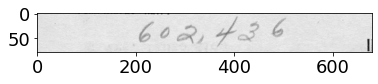

In [57]:
plt.imshow(img, cmap="gray")

In [58]:
!ls -lrt

total 48424
drwxrwxr-x 2 1000 1000   110592 Apr 19 01:01 crops
drwxr-xr-x 1 root root     4096 May  6 13:44 sample_data
drwxrwxr-x 2 1000 1000   110592 May 31 16:41 trcrops
drwx------ 6 root root     4096 May 31 16:49 gdrive
-rw------- 1 root root  2214807 Jun  1 02:43 ID-trcrops.tgz
-rw------- 1 root root 47138662 Jun  1 02:43 ID-crops.tgz


In [59]:
files = glob('trcrops/*.png')
print(f'{len(files)} files found')

1904 files found


In [60]:
shuffle(files)

In [61]:
tnum = int(0.75 * len(files))
tnum

1428

In [62]:
train_files = files[:tnum]
test_files = files[tnum:]

In [63]:
class WRAIDDataset(Dataset): 
    def __init__(self, files, transform=None):
        self.files = files
        self.map = {"01281452ta": 600000,
                    "01281462ta": 601800,
                    "01281463ta": 602000,
                    "01281464ta": 602200,
                    "01281465ta": (602400, (96, -1)),
                    "01281466ta": 602600,
                    "01281467ta": 602800,
                    "01281468ta": 603000,
                    "01281469ta": 603200,
                    "01281470ta": 603400,
                    "01281471ta": 603600
                   }
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        file = self.files[index]
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 28), cv2.INTER_LINEAR)
        parts = file.split('_')
        
        if len(parts) == 5:
            num = parts[3].split('ta')[-1]
            key = parts[3].split('ta')[0] + 'ta'
        else:
            assert(len(parts) == 6)
            num = parts[4]
            key = parts[3]
        
        num = int(num)
        val = self.map[key]
        if isinstance(val, tuple):
            base = val[0]
            entry = val[1]
            cutoff, adj = entry
            if num >= cutoff:
                # print(f'{num} over {cutoff}, applying {adj}')
                ID = base + num + adj
            else:
                ID = base + num
        else:
            base = val
            ID = base + num
            
        ID = str(ID)
        ID = ID[:3] + ',' + ID[3:]
        label = torch.IntTensor(7).fill_(0)
        for k in range(7):
            if ID[k].isdigit():
                label[k] = int(ID[k])
            else:
                label[k] = 10
        
        if self.transform:
            image = self.transform(image=image)['image']

        return (image.permute(1,0), label)

In [64]:
def statX(inp):
    print(f'min={inp.min():.2f}, max={inp.max():.2f}, mean={inp.mean():.2f}, var={inp.var():.2f}, std={inp.std():.2f}')

In [65]:
train_transform = A.Compose([
    #A.ShiftScaleRotate(shift_limit=0A.0625, scale_limit=0.50, rotate_limit=5, p=.75),
    #A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=3, p=.75),
    #A.OpticalDistortion(shift_limit=0.01, distort_limit=0.01, p=0.5),
    # A.HueSaturationValue(p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensor(),
])

In [66]:
train_set = WRAIDDataset(train_files, train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

In [67]:
data = next(iter(train_loader))

tensor([ 6,  0,  3, 10,  7,  5,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.24, std=0.49


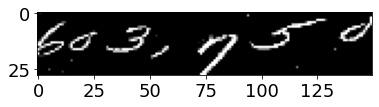

tensor([ 6,  0,  1, 10,  8,  6,  5], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.83, var=0.24, std=0.49


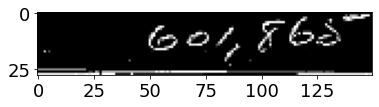

tensor([ 6,  0,  1, 10,  9,  8,  4], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.24, std=0.49


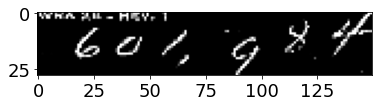

tensor([ 6,  0,  2, 10,  3,  6,  5], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.23, std=0.48


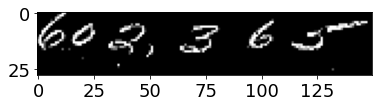

tensor([ 6,  0,  3, 10,  7,  8,  3], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.82, var=0.27, std=0.52


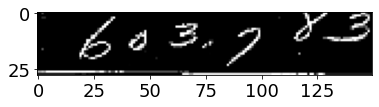

tensor([ 6,  0,  2, 10,  3,  2,  1], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.84, var=0.24, std=0.49


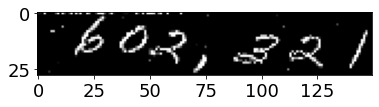

tensor([ 6,  0,  3, 10,  6,  4,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.24, std=0.49


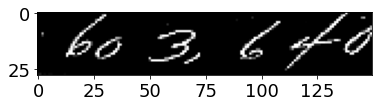

tensor([ 6,  0,  2, 10,  4,  3,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.89, var=0.17, std=0.41


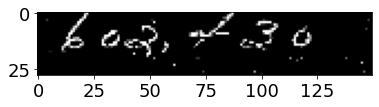

tensor([ 6,  0,  3, 10,  7,  9,  2], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.83, var=0.26, std=0.51


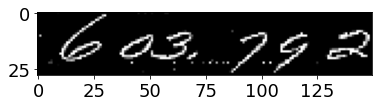

tensor([ 6,  0,  3, 10,  7,  1,  1], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.87, var=0.19, std=0.44


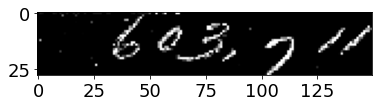

tensor([ 6,  0,  2, 10,  9,  8,  4], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.84, var=0.25, std=0.50


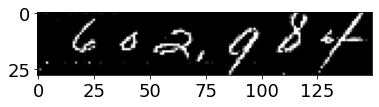

tensor([ 6,  0,  3, 10,  2,  7,  5], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.81, var=0.29, std=0.53


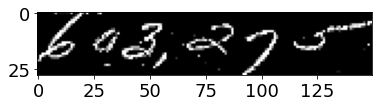

tensor([ 6,  0,  3, 10,  7,  5,  3], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.88, var=0.18, std=0.43


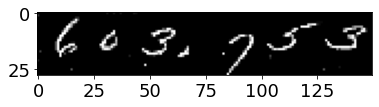

tensor([ 6,  0,  2, 10,  8,  8,  4], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.84, var=0.24, std=0.49


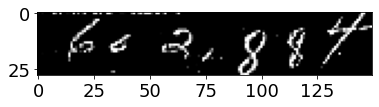

tensor([ 6,  0,  2, 10,  7,  4,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.83, var=0.27, std=0.52


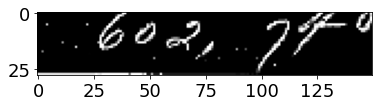

tensor([ 6,  0,  2, 10,  8,  3,  6], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.86, var=0.21, std=0.46


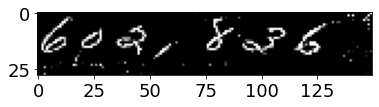

tensor([ 6,  0,  2, 10,  7,  0,  8], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.86, var=0.23, std=0.48


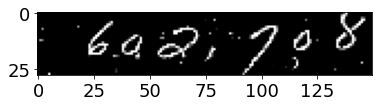

tensor([ 6,  0,  0, 10,  0,  5,  5], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.90, var=0.16, std=0.40


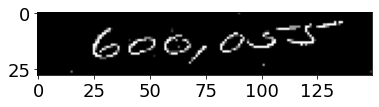

tensor([ 6,  0,  2, 10,  6,  3,  8], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.86, var=0.22, std=0.47


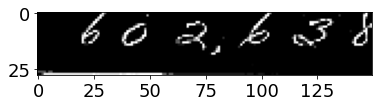

tensor([ 6,  0,  0, 10,  1,  5,  2], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.21, std=0.46


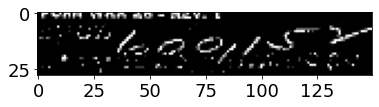

tensor([ 6,  0,  2, 10,  3,  6,  6], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.87, var=0.21, std=0.46


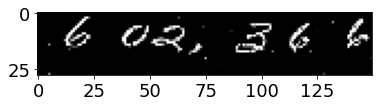

tensor([ 6,  0,  3, 10,  7,  1,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.86, var=0.20, std=0.45


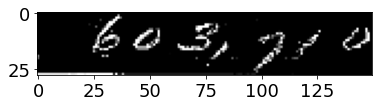

tensor([ 6,  0,  0, 10,  0,  0,  6], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.93, var=0.10, std=0.32


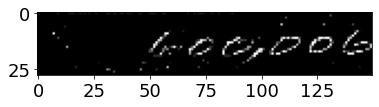

tensor([ 6,  0,  3, 10,  7,  9,  3], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.84, var=0.25, std=0.50


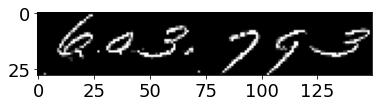

tensor([ 6,  0,  2, 10,  3,  3,  1], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.88, var=0.19, std=0.44


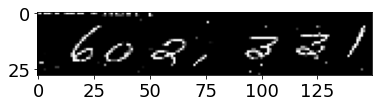

tensor([ 6,  0,  2, 10,  6,  7,  5], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.86, var=0.23, std=0.48


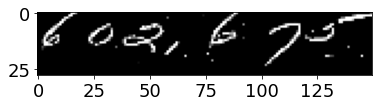

tensor([ 6,  0,  3, 10,  6,  0,  7], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.84, var=0.25, std=0.50


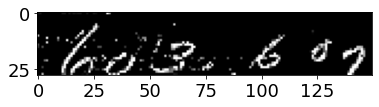

tensor([ 6,  0,  2, 10,  6,  2,  9], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.22, std=0.47


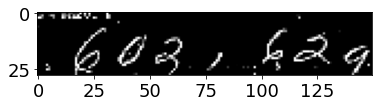

tensor([ 6,  0,  2, 10,  3,  4,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.24, std=0.49


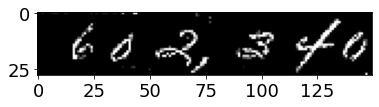

tensor([ 6,  0,  3, 10,  2,  0,  1], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.85, var=0.23, std=0.48


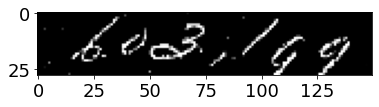

tensor([ 6,  0,  2, 10,  2,  5,  8], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.83, var=0.26, std=0.51


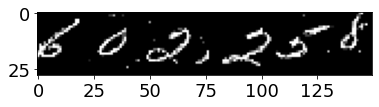

tensor([ 6,  0,  3, 10,  0,  3,  0], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.88, var=0.19, std=0.44


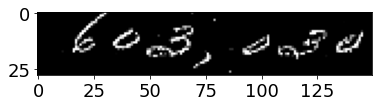

In [68]:
for k in range(32):
    print(data[1][k])
    statX(data[0][k])
    plt.imshow(data[0][k], cmap='gray')
    plt.show()

In [69]:
val_transform = A.Compose([
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensor(),
])

In [70]:
val_set = WRAIDDataset(test_files, val_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [71]:
data = next(iter(val_loader))

tensor([ 6,  0,  2, 10,  0,  7,  7], dtype=torch.int32)
min=-1.00, max=1.00, mean=-0.84, var=0.26, std=0.51


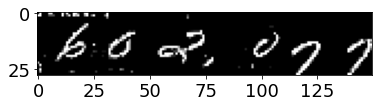

In [72]:
for k in range(1):
    print(data[1][k])
    statX(data[0][k])
    plt.imshow(data[0][k], cmap='gray')
    plt.show()

In [73]:
epochs = 50
num_classes = 12
blank_label = 11
image_height = 28
gru_hidden_size = 64
gru_num_layers = 2
cnn_output_height = 2
digits_per_sequence = 7
number_of_sequences = 10000

In [74]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 3), stride=2)
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [75]:
model = CRNN()

In [76]:
inp = torch.randn((1,1,28,150))
inp.shape

torch.Size([1, 1, 28, 150])

In [77]:
out = model(inp)

In [78]:
out.shape

torch.Size([1, 16, 12])

In [80]:
cnn_output_width = out.shape[1]
cnn_output_width

16

In [82]:
criterion = nn.CTCLoss(blank=blank_label, reduction='sum', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [83]:
# ================================================ TRAINING MODEL ======================================================
best_correct = 0
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    model.train()
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        #batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        # x_train = x_train.view(x_train.shape[0], 1, x_train.shape[2], -1)
        batch_size, h, w = x_train.shape
        x_train = x_train.reshape(batch_size, 1, h, w)
        optimizer.zero_grad()
        
        y_pred = model(x_train)
        
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        
        loss.backward()
        optimizer.step()
        
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    model.eval()
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        
        batch_size, h, w = x_val.shape
        x_val = x_val.reshape(batch_size, 1, h, w)

        with torch.set_grad_enabled(False):
            y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    # save best weights
    if val_correct > best_correct:
      best_correct = val_correct
      print("Best model seen, saving weights...")
      torch.save(model.state_dict(), "/content/gdrive/MyDrive/CRNN_ID.pth")
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

100%|██████████| 45/45 [00:06<00:00,  7.03it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 201.88it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:06<00:00,  7.08it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 196.11it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:06<00:00,  7.11it/s]
TRAINING. Correct:  7 / 1428 = 0.004901960784313725
100%|██████████| 476/476 [00:02<00:00, 197.71it/s]
Best model seen, saving weights...
TESTING. Correct:  12 / 476 = 0.025210084033613446
100%|██████████| 45/45 [00:06<00:00,  7.01it/s]
TRAINING. Correct:  158 / 1428 = 0.11064425770308123
100%|██████████| 476/476 [00:02<00:00, 196.75it/s]
Best model seen, saving weights...
TESTING. Correct:  60 / 476 = 0.12605042016806722
100%|██████████| 45/45 [00:06<00:00,  7.03it/s]
TRAINING. Correct:  487 / 1428 = 0.34103641456582634
100%|██████████| 476/476 [00:02<00:00, 185.54it/s]
Best model seen, saving weights...
TESTI

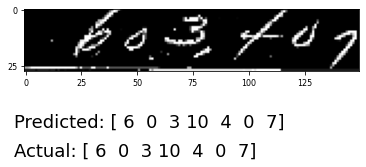

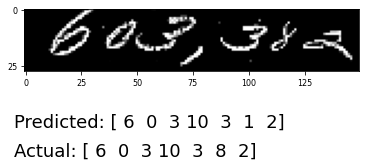

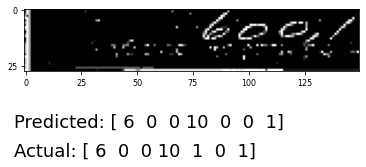

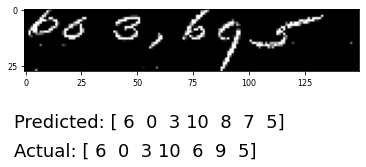

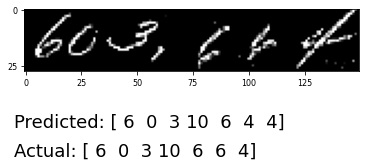

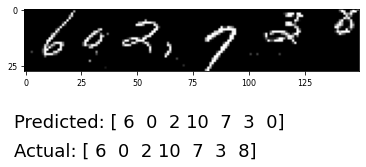

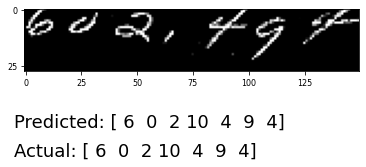

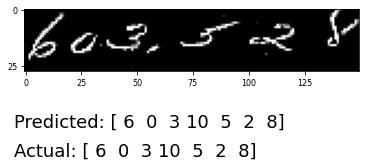

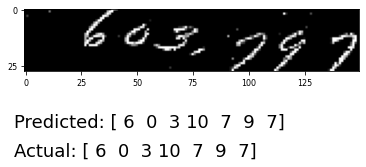

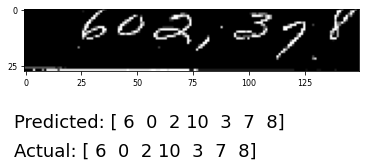

In [84]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))

batch_size, h, w = x_test.shape
x_test = x_test.reshape(batch_size, 1, h, w)

with torch.no_grad():
    y_pred = model(x_test)

y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j].view(h, w), cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()

In [99]:
IMAGE_WIDTH = 350
comma_label = 10
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


In [115]:
def predict_cluster(image_path):    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 11)
    left = np.array([x for x in range(0, image.shape[1]-IMAGE_WIDTH, 10)])
    
    subimages = []
    for l in left:
        sub = image[:,l:l+IMAGE_WIDTH].copy()
        sub = cv2.resize(sub, (150, 32), cv2.INTER_LINEAR)
        sub = test_transforms(sub)
        subimages.append(sub)
    
    super = torch.stack(subimages, dim=0)

    with torch.no_grad():
        pred = model(super)

    pred = pred.permute(1, 0, 2)

    _, max_index = torch.max(pred, dim=2)

    predictions = []
    for i in range(super.shape[0]):
      raw_prediction = list(max_index[:, i].cpu().numpy())
      prediction = [str(c) if c != comma_label else "," for c, _ in groupby(raw_prediction) if c != blank_label]
      predictions.append(''.join(prediction))

    plt.imshow(image, cmap='gray')
    plt.show()

    return predictions

In [123]:
from collections import Counter

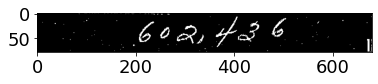

['600,602', '60,60,21', '60,60,21', '60,060218', '60,6021,9', '6060,2,15', '60,60,2,194', '60600,2,14', '606002,14', '6002,14', '6002,43', '602,43', '602,43', '602,43', '6002,430', '6002,436', '6002,436', '602,436', '602,436', '602,436', '602,436', '602,436', '602,436', '602,4306', '602,4636', '602,4636', '60,460306', '0,463,06', ',1,46306', '601463,06', '6043,06', '60403,06', '60403,0600']
[('602,436', 6)]


In [126]:
predictions = predict_cluster("crops/cubanc_35_1_01281465ta36_id.png")
print(predictions)
predictions = Counter(predictions)
print(predictions.most_common(1))
final_set = []
for p in predictions:
  if len(p) == 7 and p.index(',') == 3:
    final_set.append(p)

In [121]:
final_set

['600,602', '602,436']